# NLP modeling on baseball subreddits

In [74]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

# EDA 

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.info() #check the dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3091 entries, 0 to 3090
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   selftext   3091 non-null   object
 1   subreddit  3091 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 48.4+ KB


We are going to predict the sub reddit based on the posts themselves which are called self text.

In [4]:
X = df['selftext']
y= df['subreddit']

In [5]:
y.value_counts(normalize = True)

0    0.507279
1    0.492721
Name: subreddit, dtype: float64

The baseline for the model is 50.7%. There are slightly more posts from the mlb subreddit than the sabermetrics one. It is close enough to 50% that it should not be a serious problem. If our model is more than accurate then the baseline it could be useful. A score that beats the baseline by a bit would suggest that different baseball subreddits talk about the game in different ways so MLB should tailor their ad campaigns by group.

EDA for nlp is somewhat limited but we can get a bar chart of the most common words that are not stop words. Stop words are very common words that aren't really relevent to the subreddit distinction (like the, this, etc).

In [6]:
cvec = CountVectorizer(stop_words='english',max_df=.98)

In [7]:
Xcvec = cvec.fit_transform(X)

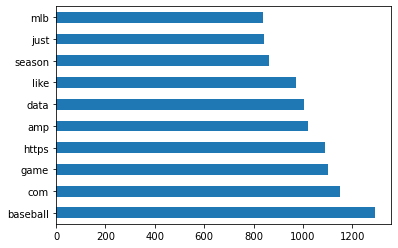

In [8]:
Xcv = pd.DataFrame(Xcvec.todense(), 
                          columns=cvec.get_feature_names())

Xcv.head()


# plot top occuring words
Xcv.sum().sort_values(ascending = False).head(10).plot(kind = 'barh');

It makes sense that baseball is the most common word. Many of the words here are baseball related like game, mlb, and season.

# Modeling

The next step is to model the data to see if we can predict which subreddit the data comes from. We will use four types of models. They are ada boosting, random forests, logistic regression, and naive bayes. We will pick the best one to use going forward. In addition for each model we will use CountVectorizer and TfidVectorizer to see which makes our model more accurate and tune over hyperparameters for both our vectorizer and our model.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y, # now we have the same ratio of both classes in the train and test data
                                                    random_state=5)

Now that the data is split into train and test sets it is time to perform the models.

# AdaBoost

AdaBoost is a boosting model that improves decision trees.

In [61]:
pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('model', AdaBoostClassifier())
])

The AdaBoost model did better with CountVectorizer than the TFidVectorizer. The AdaBoost TFidVectorizer model can be found in the other models notebook.

In [62]:
pipe_params1 = { #set up parameters for vectorizer and model
    'cvec__stop_words': ['english'],
    'cvec__max_features': [500, 1000], 
    'cvec__min_df': [2], 
    'cvec__max_df': [.9, .95, .98],
    'cvec__ngram_range': [(1,1), (1,2)], 
    'model__n_estimators': [50,100],
}

In [63]:
gs1 = GridSearchCV(pipe1, pipe_params1, cv =3) # 3 fold cross validation was used because 5 was taking too much computational time

In [64]:
gs1.fit(X_train, y_train)  #tune over hyper parameters

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('model', AdaBoostClassifier())]),
             param_grid={'cvec__max_df': [0.9, 0.95, 0.98],
                         'cvec__max_features': [500, 1000], 'cvec__min_df': [2],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english'],
                         'model__n_estimators': [50, 100]})

In [65]:
print(gs1.best_params_)

{'cvec__max_df': 0.9, 'cvec__max_features': 1000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'model__n_estimators': 100}


Only one-grams are included in the model. All the models did better when stop words were removed.

In [66]:
print(gs1.best_score_)

0.8753209016750564


In [67]:
gs1.score(X_train, y_train), gs1.score(X_test, y_test)

(0.9383088869715271, 0.888745148771022)

Overall this model is pretty good. It has an accuracy of almost 90%. However there is some overfitting. We will see if one of the other models performs better. Another way to look at the results of the model is a confusion matrix.

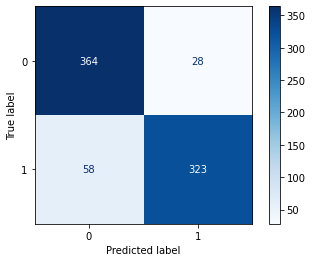

In [68]:
preds_ab = gs1.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds_ab).ravel()
plot_confusion_matrix(gs1, X_test, y_test, cmap='Blues');

Looking at the confusion matrix it looks like the model has some false negatives. In our case a false negative is the model misclassifying a post from the sabermetric subreddit as being from the mlb subreddit. While accuracy is the main metric we will use for this project we can use other metrics to get more insight into how the model is performing.

In [70]:
recall = tp/(tp +fn)
recall

0.847769028871391

The recall score is lower than the accuracy score. The model is classifying a higher percentage of sabermetric posts as mlb posts then the other way around.

In [71]:
precision = tp/(tp +fp)
precision

0.9202279202279202

The precision is good. There are not many false positives. 

In [72]:
specificity = tn/(tn +fp)
specificity

0.9285714285714286

The specificity is good for the same reason as the precision.

In [73]:
npv = tn/(tn + fn)
npv

0.8625592417061612

This last metric is negative predictive value. It is a measure of the percentage of negative predictions by the model which are correct. It is a negative version of precision. It is not commonly used but we decided to include it since in this case we don't care any more about predicting positives than predicting negatives.

It is lower than accuracy for the same reason recall is.

# Random Forests

Random Forests are a bagging method used to improve the performance of decision trees. The random forests model also did better with CountVectorizer then it did with TFidVectorizer.

In [23]:
pipe2 = Pipeline([
    ('cvec', CountVectorizer()),
    ('model', RandomForestClassifier())
])

In [24]:
pipe_params2 = {
    'cvec__stop_words': ['english'],
    'cvec__max_features': [500, 1000,2000],
    'cvec__min_df': [2],
    'cvec__max_df': [.9, .95, .98],
    'cvec__ngram_range': [(1,1), (1,2)],
    'model__n_estimators': [50,100],
    'model__max_depth': [None, 1, 2, 3]
}

In [25]:
gs2 = GridSearchCV(pipe2, pipe_params2, cv =3)

In [26]:
gs2.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('model', RandomForestClassifier())]),
             param_grid={'cvec__max_df': [0.9, 0.95, 0.98],
                         'cvec__max_features': [500, 1000, 2000],
                         'cvec__min_df': [2],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english'],
                         'model__max_depth': [None, 1, 2, 3],
                         'model__n_estimators': [50, 100]})

In [27]:
print(gs2.best_params_)

{'cvec__max_df': 0.9, 'cvec__max_features': 2000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'model__max_depth': None, 'model__n_estimators': 50}


The max depth is none so the depth of the random forests model is not being limited. Both one-grams and two-grams are included in the model.

In [28]:
print(gs2.best_score_)

0.8852378526566972


In [29]:
gs2.score(X_train, y_train), gs2.score(X_test, y_test)

(0.998274374460742, 0.890038809831824)

The random forests model has a slightly higher accuracy then the adaboosting model. However it has serious overfitting. We will see if either of the other two models can beat these.

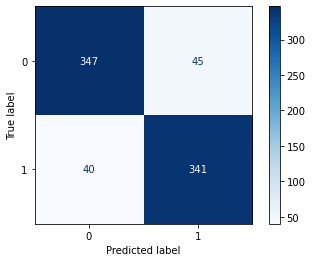

In [30]:
preds_rf = gs2.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds_rf).ravel()
plot_confusion_matrix(gs2, X_test, y_test, cmap='Blues');

Looking at the confusion matrix it seems that the random forests model is has a similar number of false negatives as false positives.

In [32]:
recall = tp/(tp +fn)
recall

0.89501312335958

In [33]:
precision = tp/(tp +fp)
precision

0.883419689119171

In [34]:
specificity = tn/(tn +fp)
specificity

0.8852040816326531

In [35]:
npv = tn/(tn + fn)
npv

0.896640826873385

The metrics confirm what we learned from the confusion matrix. All of the are betweeen 0.88 and 0.90. 

# Logistic Regression

Logistic Regression is a classification model that uses the sigmoid function. Unlike the other two models we have done so far, the logistic regression model had a higher accuracy with the TfidVectorizer than the CountVectorizer.

In [107]:
pipe3 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('model', LogisticRegression())
])

In [108]:
pipe_params3 = {
     'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)],
    'model__C': [1, 0.1, 0.01], 
    'model__solver': ['liblinear']
}

In [109]:
gs3 = GridSearchCV(pipe3, pipe_params3, cv =5)

In [110]:
gs3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('model', LogisticRegression())]),
             param_grid={'model__C': [1, 0.1, 0.01],
                         'model__solver': ['liblinear'],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [111]:
print(gs3.best_params_)

{'model__C': 1, 'model__solver': 'liblinear', 'tvec__max_features': 5000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}


Alpha is the inverse of C so the best alpha was 1. The max features was higher in this model then any other model. One-gram and two-gram sequences were included.

In [112]:
print(gs3.best_score_)

0.9197465926863782


In [113]:
gs3.score(X_train, y_train), gs3.score(X_test, y_test)

(0.9723899913718723, 0.9236739974126779)

The logistic regression model has a higher accuracy then the adaboost model and the random forests model. It is also overfitting but the overfit is no worse than the other two models. Therefore it is best model so far.

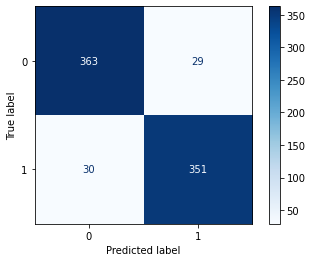

In [114]:
preds_logreg = gs3.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds_logreg).ravel()
plot_confusion_matrix(gs3, X_test, y_test, cmap='Blues');

Based on the confusion matrix, the logistic regression model has a similar rate of false positives and false negatives.

In [116]:
recall = tp/(tp +fn)
recall

0.9212598425196851

In [117]:
precision = tp/(tp +fp)
precision

0.9236842105263158

In [118]:
specificity = tn/(tn +fp)
specificity

0.9260204081632653

In [119]:
npv = tn/(tn + fn)
npv

0.9236641221374046

All of the metrics are at around 0.92 along with accuracy. We have one more model to try.

# Naive Bayes 

The naive bayes model had better results with the TfidVectorizer. Naive bayes is a model that uses bayesian statistics to generate predictions. It is a very efficient model. 

In [76]:
pipe4 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

In [77]:
pipe_params4 = {
     'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [78]:
gs4 = GridSearchCV(pipe4, pipe_params4, cv =5)

In [79]:
gs4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [80]:
print(gs4.best_params_)

{'tvec__max_features': 4000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}


All the models did better when taking out stop words. There is a lower max features in this model then the logistic regression model. Only 1-grams were included.

In [81]:
print(gs4.best_score_)

0.9124162135994638


In [83]:
gs4.score(X_train, y_train), gs4.score(X_test, y_test)

(0.955565142364107, 0.926261319534282)

The naive bayes model is the most accurate model on the testing data. It is slightly more accurate than the logistic regression model. The big advantage it has over the logistic regression model is that it is less overfit. Of the four models, the naive bayes is the best one.

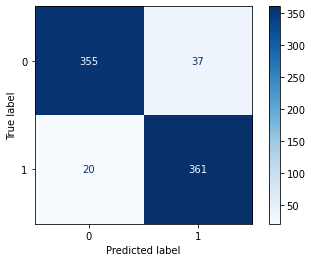

In [84]:
preds_nb = gs4.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds_nb).ravel()
plot_confusion_matrix(gs4, X_test, y_test, cmap='Blues');

One downside to the naive bayes model is it is not quite as good at avoiding false positives as the logistic regression model. That means it has a higher tendency to classify posts in the mlb subreddit as being in the sabermetric one instead.

In [86]:
recall = tp/(tp +fn)
recall

0.94750656167979

In addition to the highest accuracy score the naive bayes model has the highest recall score as well. 

In [87]:
precision = tp/(tp +fp)
precision

0.907035175879397

In [88]:
specificity = tn/(tn +fp)
specificity

0.9056122448979592

The naive bayes model has a lower precision and specificity than the logistic regression and adaboosting models. This is a drawback however since we mostly care about accuracy it is still our best model. 

In [89]:
npv = tn/(tn + fn)
npv

0.9466666666666667

The naive bayes model has the highest npv score of our models.

# Conclusion

We were successfully able to model the difference between our two subreddits. That means there are differences between how the sabermetric community talks about baseball compared to MLB fans at large. MLB might want to have a seperate outreach for them to have the biggest impact.

The naive bayes model with TfidVectorizer was the most effective model at accurately predicting the test data and had the least overfitting. Therefore it is the model that we will use going forward to study this issue.

# Further Work

Now that we have a model that can predict which subreddit the post comes from we can do more research on the differences between the two. Then we can recommend how to appeal to each group individually. Though targeted ads we hope to grow greater fan interest and engagement. 

Fans of sabermetrics are not the only sub group of MLB fans. Running this model comparing the mlb subreddits to other baseball subreddits might give us a good idea of other groups of fans who might warrent targeted outreach

Other further work can be done improving the model and trying other models. Other models like SVM, gradient boosting, and neural networks may have gotten even better results. Also there are always more hyperparameters to tune. However, overall our model has an accuracy of over 90% so we feel comfortable using it going forward.